In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

In [2]:
train_df = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
eval_df = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

In [3]:
train_df.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


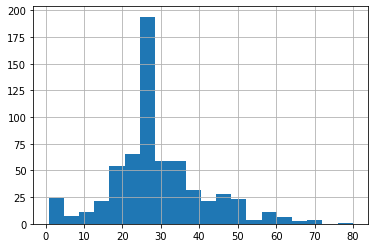

In [5]:
train_df.age.hist(bins=20)

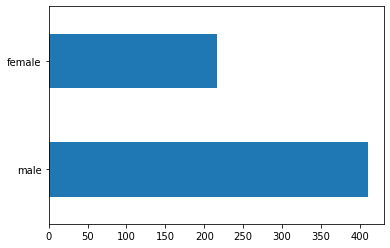

In [6]:
train_df.sex.value_counts().plot(kind='barh')

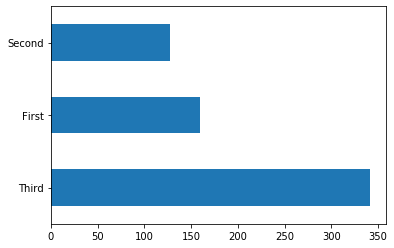

In [8]:
train_df['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

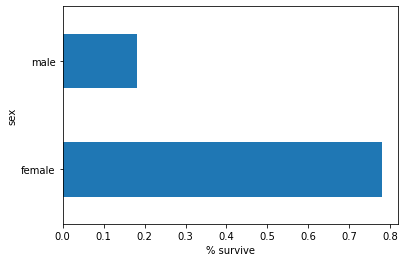

In [10]:
pd.concat([train_df, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [11]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [13]:
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = train_df[feature_name].unique()
    feature_columns.append(
        tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)
    )
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(
        tf.feature_column.numeric_column(feature_name, dtype=tf.float32)
    )

In [15]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if(shuffle):
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(train_df, y_train)
eval_input_fn = make_input_fn(eval_df, y_eval, num_epochs=1, shuffle=False)

In [17]:
ds = make_input_fn(train_df, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Features: ', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['class'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())

Features:  ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'First' b'Third' b'Third' b'Third' b'Third' b'Third' b'Third' b'Third'
 b'Second' b'Second']

A batch of Labels: [0 1 0 0 1 0 0 1 0 0]


In [18]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[31.],
       [ 5.],
       [28.],
       [28.],
       [18.],
       [28.],
       [11.],
       [28.],
       [39.],
       [60.]], dtype=float32)

In [19]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures(
    [tf.feature_column.indicator_column(gender_column)]
)(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [20]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.75, 'accuracy_baseline': 0.625, 'auc': 0.83281296, 'auc_precision_recall': 0.7920674, 'average_loss': 0.47641394, 'label/mean': 0.375, 'loss': 0.46874565, 'precision': 0.6701031, 'prediction/mean': 0.3851032, 'recall': 0.65656567, 'global_step': 200}


In [21]:
age_x_gender = tf.feature_column.crossed_column(
    ['age', 'sex'], hash_bucket_size=100
)

In [22]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(
    feature_columns=feature_columns + derived_feature_columns
)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.780303, 'accuracy_baseline': 0.625, 'auc': 0.85166824, 'auc_precision_recall': 0.78687054, 'average_loss': 0.4727038, 'label/mean': 0.375, 'loss': 0.46283993, 'precision': 0.7411765, 'prediction/mean': 0.3239014, 'recall': 0.6363636, 'global_step': 200}


INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/wh/h43cl57j4ljf1x5_4p1bqmx80000gn/T/tmpiymxy_ow/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


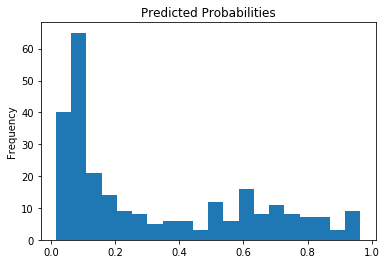

In [23]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='Predicted Probabilities')

(0, 1.05)

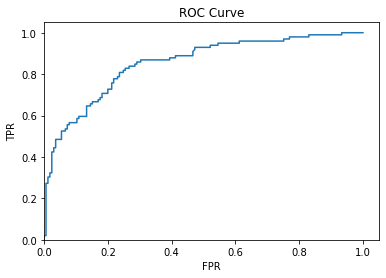

In [26]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0, )
plt.ylim(0, )